# Lunar Lander

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

import pandas as pd

In [6]:
from vae_recurrent import VAE, create_decoder, create_encoder
from transition_gru import TransitionGRU
from recurrent_agent import DAIFAgentRecurrent
from prior_model import PriorModelBellman
from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward
from ddpg import *

In [7]:
from util import random_observation_sequence, transform_observations, test_policy, habit_policy
from train_agent import train_single_agent

In [8]:
# from identity_vae import IdentityVAE, identity_encoder, identity_decoder

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np



class DAIFAgentRecurrent:

    def __init__(self,
                 prior_model,
                 vae,
                 tran,
                 habitual_action_net,
                 given_prior_mean=None,
                 given_prior_stddev=None,
                 agent_time_ratio=6,
                 actions_to_execute_when_exploring=2,
                 planning_horizon=15,
                 n_policies=1500,
                 n_cem_policy_iterations=2,
                 n_policy_candidates=70,
                 train_vae=True,
                 train_tran=True,
                 train_prior_model=True,
                 train_habit_net=True,
                 train_with_replay=True,
                 train_after_exploring=True,
                 use_kl_extrinsic=True,
                 use_kl_intrinsic=True,
                 use_FEEF=True,
                 use_fast_thinking=False,
                 uncertainty_tolerance=0.05,
                 habit_model_type="name_of_model"):

        super(DAIFAgentRecurrent, self).__init__()

        # parameters for slow policy planning
        self.planning_horizon = planning_horizon
        self.n_policy_candidates = n_policy_candidates
        self.n_policies = n_policies
        self.n_cem_policy_iterations = n_cem_policy_iterations

        # flags for whether or not we are training models or using pretrained models and when we should train
        self.train_vae = train_vae
        self.train_tran = train_tran
        self.train_habit_net = train_habit_net
        self.train_prior = train_prior_model
        self.train_with_replay = train_with_replay
        self.train_after_exploring = train_after_exploring

        # do we use the kl divergence for extrinsic vs intrinsic
        self.use_kl_intrinsic = use_kl_intrinsic
        self.use_kl_extrinsic = use_kl_extrinsic

        # do we use the FEEF or EFE?
        self.use_FEEF = use_FEEF

        # given prior values
        self.given_prior_mean = given_prior_mean
        self.given_prior_stddev = given_prior_stddev

        # full vae
        self.model_vae = vae
        self.tran = tran
        self.prior_model = prior_model
        self.habit_action_model = habitual_action_net

        # how much is the agents planning time compressed compared to the simulation time
        self.agent_time_ratio = agent_time_ratio
        self.actions_to_execute_when_exploring = actions_to_execute_when_exploring
        self.time_step = 0
        self.exploring = False

        # track the hidden state of the transition gru model so we can use it to train
        self.tran_hidden_state = None
        self.tran_hidden_state_pre_exploring = None
        self.prev_tran_hidden_state = None

        # store the full observations for the episode so we can train using replay
        self.full_observation_sequence = []
        self.full_action_sequence = []
        self.full_reward_sequence = []

        # store the observations while the agent is in exploration mode
        self.exploring_observation_sequence = []
        self.exploring_action_sequence = []
        self.exploring_reward_sequence = []

        # store the observations at the world time scale
        self.env_time_scale_observations = []

        self.policy_left_to_execute = [None]
        self.previous_observation = None
        self.action_being_executed = None
        self.action_being_executed = [0]*self.tran.action_dim

        self.use_fast_thinking = use_fast_thinking
        self.habit_model_type = habit_model_type
        self.uncertainty_tolerance = uncertainty_tolerance
        self.num_fast_thinking_choices = 0


    def perceive_and_act(self, observation, reward, done):
        """
        The function called to have the agent interact with the environment
        We assume the agent gets a transformed/noisy observation from the environment and then returns an action

        TODO: possibly the agent returns some other information for logging and showing experiments

        :param observation:
        :param reward:
        :param done:
        :return:
        """

        # track the world time scale observation sequence
        self.env_time_scale_observations.append(observation)

        # if the episode is finished, then do any training on the full data set
        if done and self.train_with_replay:

            print("training on full data")
            print(self.num_fast_thinking_choices, len(self.full_action_sequence))

            # add the final observation and reward we observed to the sequences
            self.full_observation_sequence.append(observation)
            self.full_reward_sequence.append(reward)

            # Call the training function on the observation sequences to train everything we need to train
            self.train_models(np.vstack(self.full_observation_sequence),
                              np.vstack(self.full_action_sequence),
                              np.array(self.full_reward_sequence),
                              None)


        # Otherwise are we at a point where we can reconsider our policy and maybe train the world model
        elif self.time_step % self.agent_time_ratio == 0:

            # add the observation to the sequence
            self.full_observation_sequence.append(observation)

            # add the reward only if it's not the first observation
            if self.time_step != 0:
                self.full_reward_sequence.append(reward)

            # We only update the model during the episode when we were exploring using the planning method and we have executed all of the actions in the policy
            if self.exploring and len(self.policy_left_to_execute) == 0:

                # print("f", self.full_observation_sequence)
                # print("e", self.full_observation_sequence[-1*(self.actions_to_execute_when_exploring + 1):])

                if self.train_after_exploring:

                    # the actions done while exploring were the last self.actions_to_execute_when_exploring
                    self.exploring_action_sequence = self.full_action_sequence[-1*self.actions_to_execute_when_exploring:]
                    self.exploring_reward_sequence = self.full_reward_sequence[-1*self.actions_to_execute_when_exploring:]
                    self.exploring_observation_sequence = self.full_observation_sequence[-1*(self.actions_to_execute_when_exploring + 1):]

                    # Call the training function on the observation sequences to train everything we need to train
                    self.train_models(np.vstack(self.exploring_observation_sequence),
                                      np.vstack(self.exploring_action_sequence),
                                      np.array(self.exploring_reward_sequence),
                                      self.tran_hidden_state_pre_exploring)

                # now we're no longer exploring
                self.exploring = False

            # print(self.action_being_executed)
            # Predict the expected observation based on the previously executed action
            action_as_array = np.array(self.action_being_executed).reshape(1, self.tran.action_dim)
            expected_observation, self.tran_hidden_state = self.predict_next_observation(self.previous_observation, action_as_array, self.prev_tran_hidden_state)

            # Now we select our action. If we aren't exploring then either we act out of habit or we might need to explore
            # I think I can check this based on whether or not there are actions left to execute in the current policy
            if not self.exploring:

                # first observation will have no previous observation
                if self.use_fast_thinking and self.previous_observation is None:
                    # self.policy_left_to_execute = self.habit_action_model(observation)
                    self.policy_left_to_execute = self.select_fast_thinking_policy(observation)
                    self.policy_left_to_execute = self.policy_left_to_execute.numpy().tolist()  # tf tensor to list
                    print("fast thinking")

                # TDOD Fix this to work however it needs to
                # we need to see what the generative model now thinks about what the expected current observation is
                elif self.use_fast_thinking and np.allclose(observation, expected_observation, atol=self.uncertainty_tolerance):  # within some tolerance

                    self.policy_left_to_execute = self.select_fast_thinking_policy(observation)
                    # self.policy_left_to_execute = self.policy_left_to_execute + np.random.normal(0, scale=self.habit_action_model.action_std_dev)
                    self.policy_left_to_execute = self.policy_left_to_execute.numpy().tolist()

                    # self.tran_hidden_state = next_tran_hidden_state
                    self.num_fast_thinking_choices += 1
                    print("fast thinking")

                # the generative model is surprised so we should use the slow deliberation for planning out a policy that balances exploration and exploitation
                else:
                    # TODO should we actually sample here?
                    # print("slow thinking")
                    policy = self.select_policy(observation)
                    policy = policy.mean().numpy()
                    policy = policy.reshape(policy.shape[0], self.tran.action_dim).tolist()
                    self.policy_left_to_execute = policy[0: self.actions_to_execute_when_exploring]

                    self.tran_hidden_state_pre_exploring = self.tran_hidden_state

                    self.exploring = True



            # finally update the previous observation and action to be the one we just had/did
            self.previous_observation = observation
            self.prev_tran_hidden_state = self.tran_hidden_state
            self.action_being_executed = self.policy_left_to_execute[0]
            self.full_action_sequence.append(self.action_being_executed)
            self.policy_left_to_execute.pop(0)

        # final updates increment the current timestep and return the action specified by the policy
        self.time_step += 1

        return self.action_being_executed


    def predict_next_observation(self, obs, action, tran_hidden_state):

        # TODO: Fix this with the transition hidden states
        if obs is None:
            return None, None
        else:
            z_mean, z_std, z = self.model_vae.encoder(obs)
            # print(z_mean.shape)
            # print(action.shape)
            z_mean = z_mean.numpy()
            z_plus_action = np.concatenate([z_mean, action], axis=1)
            # print(z_mean)
            # print(action)
            # print(z_plus_action)

            z_plus_action = z_plus_action.reshape(1, 1, z_plus_action.shape[1])
            # print(z_plus_action)

            next_latent_mean, next_latent_sd, next_hidden_state, _ = self.tran((z_plus_action, tran_hidden_state))

            next_observation = self.model_vae.decoder(next_latent_mean)
            # print(next_observation)
            return next_observation.numpy(), next_hidden_state


    # We use this function to reset the hidden state of the transition model when we want to train on the full data set
    def reset_tran_hidden_state(self):
        self.tran_hidden_state = None


    def reset_all_states(self):
        self.time_step = 0
        self.exploring = False

        # track the hidden state of the transition gru model so we can use it to train
        self.tran_hidden_state = None

        # store the full observations for the episode so we can train using replay
        # self.complete_observation_sequence = []
        self.full_observation_sequence = []
        self.full_action_sequence = []
        self.full_reward_sequence = []

        # store the observations while the agent is in exploration mode
        self.exploring_observation_sequence = []
        self.exploring_action_sequence = []
        self.exploring_reward_sequence = []

        self.policy_left_to_execute = []
        self.previous_observation = None
        self.action_being_executed = [0]*self.tran.action_dim

        self.num_fast_thinking_choices = 0


    def train_models(self, observations_full, actions, rewards, tran_hidden_state_pre_obs):

        pre_observations = observations_full[:-1]
        post_observations = observations_full[1:]

        # find the actual observed latent states using the vae
        pre_latent_mean, pre_latent_stddev, pre_latent = self.model_vae.encoder(pre_observations)
        post_latent_mean, post_latent_stddev, post_latent = self.model_vae.encoder(post_observations)

        #### TRAIN THE TRANSITION MODEL ####
        if self.train_tran:

            num_observations = pre_observations.shape[0]
            # observation_dim = pre_observations.shape[1]
            action_dim = actions.shape[1]
            latent_dim = self.model_vae.latent_dim

            # set up the input training data that we use to train the transition model
            z_train = np.concatenate([np.array(pre_latent_mean), actions], axis=1)

            # we use the sequence to find the right hidden states to use as input
            z_train_seq = z_train.reshape((1, num_observations, latent_dim + action_dim))
            z_train_singles = z_train.reshape(num_observations, 1, latent_dim + action_dim)

            # the previous hidden state is the memory after observing some sequences but it might be None if we're just starting
            if tran_hidden_state_pre_obs is None:
                tran_hidden_state_pre_obs = np.zeros((1, self.tran.hidden_units))

            # find the hidden states at t=0, t=1, t=2, ..., t=num_observations - 1
            _, _, _, h_states = self.tran((z_train_seq, tran_hidden_state_pre_obs))

            # squeeze so we make the shape [num_observations, hidden_units]
            h_states = tf.squeeze(h_states)

            # exclude the last state as this will become the hidden state later on. next hidden state will become our new memory
            h_states_for_training = h_states[:-1]
            # next_hidden_state = h_states[-1]

            # add the current hidden state we saved to the start. This has h0, h1, h2, .. h=num_observations - 1
            h_states_for_training = tf.concat([tran_hidden_state_pre_obs, h_states_for_training], axis=0)

            # use the hidden states with the pre and post observations to train transition model
            self.tran.fit((z_train_singles, h_states_for_training), (post_latent_mean, post_latent_stddev), epochs=self.tran.train_epochs, verbose=self.tran.show_training, batch_size=z_train_singles.shape[0])

            # now find the new predicted hidden state that we will use for finding the policy
            # TODO not sure if I should pass the old hidden state or reset it to 0
            _, _, final_hidden_state, h_states = self.tran((z_train_seq, tran_hidden_state_pre_obs))
            # _, _, final_hidden_state, _ = self.tran((z_train_seq, None))

            z_pred, _, _, _ = self.tran((z_train_singles, h_states_for_training))
            # print(h_states)
            # print(final_hidden_state)
            # print(h_states[:, -2, :])
            self.prev_tran_hidden_state = h_states[:, -2, :]
            self.tran_hidden_state = final_hidden_state


        #### TRAIN THE VAE ####
        if self.train_vae:
            # train the vae model on post_observations because these are all new
            # self.model_vae.fit(pre_observations_raw, epochs=self.vae_train_epochs, verbose=self.show_vae_training)
            self.model_vae.fit(pre_observations, epochs=self.model_vae.train_epochs, verbose=self.model_vae.show_training, batch_size=pre_observations.shape[0])


        #### TRAIN THE PRIOR MODEL ####
        # TODO fix how this part should work
        if self.train_prior:
            # self.prior_model.train(post_observations, rewards, verbose=self.show_prior_training)
            # if max(rewards) > 0:
                # self.prior_model.train(post_observations, rewards)
            self.prior_model.train(post_latent_mean, rewards)


        #### TRAIN THE HABIT ACTION NET ####
        if self.train_habit_net:

            # prior_preferences_mean = tf.convert_to_tensor(self.given_prior_mean, dtype="float32")
            # prior_preferences_stddev = tf.convert_to_tensor(self.given_prior_stddev, dtype="float32")
            #
            # prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)
            #
            # external_efe = -1 * tf.math.log(prior_dist.prob(post_observations))
            # external_efe = external_efe.numpy().reshape(external_efe.shape[0], 1)
            #
            # one_over_external_efe = 1/external_efe
            #
            # ten_minus_external_efe = -1*external_efe + 10

            # ten_minus_external_efe = ten_minus_external_efe.numpy().reshape(ten_minus_external_efe.shape[0], 1)

            # one_over_external_efe = one_over_external_efe.numpy().reshape(one_over_external_efe.shape[0], 1)
            # print(one_over_external_efe.shape)

            # print(post_observations)
            # print(one_over_external_efe)

            # obs_utilities = self.prior_model(pre_observations)
            # obs_utilities = tf.reduce_sum(obs_utilities, axis=-1)
            # obs_utilities = obs_utilities.numpy().reshape(obs_utilities.shape[0], 1)
            # # print(obs_utilities)
            #
            # cum_rewards = compute_discounted_cumulative_reward(obs_utilities, self.habit_action_model.discount_factor)

            if self.habit_model_type == "PG":
                # rewards = rewards.reshape(rewards.shape[0], 1)
                # cum_rewards = compute_discounted_cumulative_reward(rewards, self.habit_action_model.discount_factor)
                # rewards_to_train_on = cum_rewards

                # TODO I think for the final state the V(s_t+1) should be set to 0
                # ADVANTAGE
                v_state = self.prior_model(pre_latent_mean)
                v_plus_one_state = self.prior_model(post_latent_mean)
                advantage = rewards + self.prior_model.discount_factor * v_plus_one_state - v_state

                # print(advantage)

                # DDPG and policy gradient interface with same function
                # self.habit_action_model.train(pre_latent_mean, actions, rewards_to_train_on, post_latent_mean)
                self.habit_action_model.train(pre_latent_mean, actions, advantage, post_latent_mean)

            if self.habit_model_type == "DDPG":
                self.habit_action_model.train(pre_latent_mean, actions, rewards, post_latent_mean)


    def select_fast_thinking_policy(self, observation):

        # TODO should you select the mean here?
        # _,  _, latent_state = self.model_vae.encoder(observation)
        latent_state,  _, _ = self.model_vae.encoder(observation)
        action = self.habit_action_model.select_action(latent_state)

        return action


    def select_policy(self, observation):
        """
        :param observation: needs to be [n, observation_dim] shape np array or tf tensor
        :return:
        """

        # TODO do you take the mean or that latent here?
        # get the latent state from this observation
        # TODO should I use the mean here?
        _,  _, latent_state = self.model_vae.encoder(observation)
        # latent_state,  _, _ = self.model_vae.encoder(observation)
        # latent_state = latent_state.numpy().reshape((1, latent_state.shape[0]))
        # print(latent_state)
        # print(latent_state)
        # select the policy
        policy_mean, policy_stddev = self.cem_policy_optimisation(latent_state)

        # return a distribution that we can sample from
        return tfp.distributions.MultivariateNormalDiag(loc=policy_mean, scale_diag=policy_stddev)


    # TODO Fix this so we can use different action dimensions
    def cem_policy_optimisation(self, latent_z):

        # need to change these two if the policy dimension changes
        mean_best_policies = tf.zeros((self.planning_horizon, self.tran.action_dim))
        std_best_policies = tf.ones((self.planning_horizon, self.tran.action_dim))

        # print(mean_best_policies)
        # print(mean_best_policies.shape)

        for i in range(self.n_cem_policy_iterations):
            policy_distr = tfp.distributions.MultivariateNormalDiag(loc=mean_best_policies, scale_diag=std_best_policies)
            policies = policy_distr.sample([self.n_policies])
            # print("p", policies.shape)
            policies = tf.clip_by_value(policies, clip_value_min=-1, clip_value_max=1)
            # policies = tf.clip_by_value(policies, clip_value_min=-1, clip_value_max=1)

            # project trajectory into the future using transition model and calculate FEEF for each policy
            policy_results = self.forward_policies(policies.numpy(), latent_z)
            FEEFs = self.evaluate_policy(*policy_results)

            # print("POLICIES", policies)
            # print("FEEFS", FEEFs)

            FEEFs = tf.convert_to_tensor(FEEFs)

            # sum over the timesteps to get the FEEF for each policy
            FEEFs_sum = tf.reduce_sum(FEEFs, axis=0)

            # multiply by -1 to find largest value which is euqivalent to smallest FEEF with top_k
            neg_FEEF_sum = -1*FEEFs_sum

            result = tf.math.top_k(neg_FEEF_sum, self.n_policy_candidates, sorted=False)
            min_FEEF_indices = result.indices

            # update the policy distributions
            mean_best_policies = tf.reduce_mean(tf.gather(policies, min_FEEF_indices), axis=0)
            std_best_policies = tf.math.reduce_std(tf.gather(policies, min_FEEF_indices), axis=0)


        # TODO not sure why we need all of this is with the x means? I think it's for training but maybe not

        # One last forward pass to gather the stats of the policy mean
        #FEEFs, next_x_means, next_x_stds = self._forward_policies(mean_best_policies.unsqueeze(1))
        # return mean_best_policies, std_best_policies, FEEFs.detach().squeeze(1), next_x_means.detach().squeeze(1), next_x_stds.detach().squeeze(1)

        return mean_best_policies, std_best_policies


    def forward_policies(self, policies, z_t_minus_one):
        """
        Forward propogate a policy and compute the FEEF of each policy
        :param z_t_minus_one:
        :return:
        """

        # stack up the new observation to have shape (self.n_policies, latent_dim) when z_t_minus is tensor with shape (1, latent_dim)
        prev_latent_mean = tf.squeeze(tf.stack([z_t_minus_one]*self.n_policies, axis=1))

        policy_posteriors = []
        policy_sds = []
        likelihoods = []
        z_means = []
        z_sds = []

        # get the starting hidden state that coressponds to the memory stored by the previous sequences. Should have shape (1, self.tran.num_hidden_units) for the observed sequence
        # extend the current hidden state to the number of policies present
        if self.tran_hidden_state is None:
            cur_hidden_state = np.zeros((self.n_policies, self.tran.hidden_units))
        else:
            cur_hidden_state = np.vstack([self.tran_hidden_state]*self.n_policies)

        # print(cur_hidden_state)

        # find the predicted latent states from the transition model
        for t in range(self.planning_horizon):

            # print(prev_latent_mean)
            # print(policies[:, t, :].shape)
            ob_plus_action = np.concatenate([prev_latent_mean, policies[:, t, :]], axis=1)
            tran_input = ob_plus_action.reshape((self.n_policies, 1, ob_plus_action.shape[1]))  # reshape to pass to GRU

            # print(tran_input.shape)

            next_latent_mean, next_latent_sd, next_hidden_state, _ = self.tran((tran_input, cur_hidden_state))  # shape = [num policies, latent dim

            # update the hidden state for use with the next policies
            cur_hidden_state = next_hidden_state

            policy_posteriors.append(next_latent_mean)
            policy_sds.append(next_latent_sd)

            next_likelihoods = self.model_vae.decoder(next_latent_mean)
            likelihoods.append(next_likelihoods)

            next_posterior_means, next_posteriors_sds, next_posteriors_z = self.model_vae.encoder(next_likelihoods)
            z_means.append(next_posterior_means)
            z_sds.append(next_posteriors_sds)

            prev_latent_mean = next_latent_mean

        return policy_posteriors, policy_sds, likelihoods, z_means, z_sds


    def evaluate_policy(self, policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd):

        if self.use_FEEF:
            return self.FEEF(policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd)
        else:
            return self.EFE(policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd)


    def FEEF(self, policy_posteriors_list, policy_sd_list, predicted_likelihood_list, predicted_posterior_list, predicted_posterior_sd_list):
        """
        Compute the FEEF for policy selection
        :param policy_posteriors:
        :param predicted_likelihood:
        :param predicted_posterior:
        :return:
        """

        FEEFs = []

        for t in range(self.planning_horizon):

            # extract the values for each time step
            predicted_likelihood = predicted_likelihood_list[t]
            policy_posteriors = policy_posteriors_list[t]
            policy_sd = policy_sd_list[t]
            predicted_posterior = predicted_posterior_list[t]
            predicted_posterior_sd = predicted_posterior_sd_list[t]

            # !!!! evaluate the EXTRINSIC KL divergence !!!!

            # convert to normal distributions
            # TODO Why is the stddev 1s here? I think because we assume it is on the true state of the world.

            if self.use_kl_extrinsic:
                likelihood_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_likelihood, scale_diag=np.ones_like(predicted_likelihood))

                if self.prior_model is None:

                    # TODO how exactly is the prior defined? After you apply transformations what is the prior
                    # create the prior distribution
                    prior_preferences_mean = tf.convert_to_tensor(np.stack([self.given_prior_mean]*self.n_policies), dtype="float32")
                    prior_preferences_stddev = tf.convert_to_tensor(np.stack([self.given_prior_stddev]*self.n_policies), dtype="float32")

                    prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)

                    kl_extrinsic = tfp.distributions.kl_divergence(likelihood_dist, prior_dist)

                # Compute the extrinisc approximation with the prior model
                else:
                    kl_extrinsic = self.prior_model.extrinsic_kl(predicted_likelihood)
                    kl_extrinsic = tf.reduce_sum(kl_extrinsic, axis=-1)

            # if we don't use extrinsic set it to zero
            else:
                kl_extrinsic = tf.zeros(self.n_policies, dtype="float")

            # !!!! evaluate the KL INTRINSIC part !!!!
            if self.use_kl_intrinsic:

                policy_posteriors_dist = tfp.distributions.MultivariateNormalDiag(loc=policy_posteriors, scale_diag=policy_sd)
                predicted_posterior_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_posterior, scale_diag=predicted_posterior_sd)

                kl_intrinsic = tfp.distributions.kl_divergence(predicted_posterior_dist, policy_posteriors_dist)

            else:
                kl_intrinsic = tf.zeros(self.n_policies, dtype="float")

            # print("Extrinsic", kl_extrinsic)
            # print("Intrinsic", kl_intrinsic)

            FEEF = kl_extrinsic - kl_intrinsic

            FEEFs.append(FEEF)

        return FEEFs


    # TODO Find out how this works with the log probability extrinsic term
    def EFE(self, policy_posteriors_list, policy_sd_list, predicted_likelihood_list, predicted_posterior_list, predicted_posterior_sd_list):
        """
        Compute the EFE for policy selection
        :param policy_posteriors:
        :param predicted_likelihood:
        :param predicted_posterior:
        :return:
        """

        EFEs = []

        for t in range(self.planning_horizon):

            # extract the values for each time step
            predicted_likelihood = predicted_likelihood_list[t]
            policy_posteriors = policy_posteriors_list[t]
            policy_sd = policy_sd_list[t]
            predicted_posterior = predicted_posterior_list[t]
            predicted_posterior_sd = predicted_posterior_sd_list[t]

            # !!!! evaluate the EXTRINSIC KL divergence !!!!

            # convert to normal distributions
            # TODO Why is the stddev 1s here? I think because we assume it is on the true state of the world.

            if self.use_kl_extrinsic:
                likelihood_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_likelihood, scale_diag=np.ones_like(predicted_likelihood))

                if self.prior_model is None:

                    # TODO how exactly is the prior defined? After you apply transformations what is the prior
                    # create the prior distribution
                    prior_preferences_mean = tf.convert_to_tensor(np.stack(self.given_prior_mean), dtype="float32")
                    prior_preferences_stddev = tf.convert_to_tensor(np.stack(self.given_prior_stddev), dtype="float32")

                    prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)

                    # compute extrinsic prior preferences term
                    efe_extrinsic = -1 * tf.math.log(prior_dist.prob(predicted_likelihood))

                # TODO Can I use the learned prior model here?
                else:
                    # efe_extrinsic = self.prior_model.extrinsic_kl(predicted_likelihood)
                    efe_extrinsic = self.prior_model.extrinsic_kl(predicted_posterior)
                    efe_extrinsic = tf.reduce_sum(efe_extrinsic, axis=-1)

            # if we don't use extrinsic set it to zero
            else:
                efe_extrinsic = tf.zeros(self.n_policies, dtype="float")

            # !!!! evaluate the KL INTRINSIC part !!!!
            if self.use_kl_intrinsic:

                policy_posteriors_dist = tfp.distributions.MultivariateNormalDiag(loc=policy_posteriors, scale_diag=policy_sd)
                predicted_posterior_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_posterior, scale_diag=predicted_posterior_sd)

                kl_intrinsic = tfp.distributions.kl_divergence(predicted_posterior_dist, policy_posteriors_dist)

            else:
                kl_intrinsic = tf.zeros(self.n_policies, dtype="float")

            # print("EX")
            # print(efe_extrinsic)
            # print("IN")
            # print(kl_intrinsic)

            EFE = efe_extrinsic - kl_intrinsic

            EFEs.append(EFE)

        return EFEs

In [10]:
# Hide GPU from visible devices
# tf.config.set_visible_devices([], 'GPU')

In [11]:
import keras
import tensorflow as tf
import numpy as np

def identity_encoder(inputs, stddev):

    return [tf.convert_to_tensor(inputs, dtype="float32"), stddev * tf.ones_like(inputs, dtype="float32"), tf.convert_to_tensor(inputs, dtype="float32")]


def identity_decoder(inputs):
    return tf.convert_to_tensor(inputs, dtype="float32")


class IdentityVAE(keras.Model):
    """
    Implements the identity mapping with standard deviation as all 1s
    """
    def __init__(self,
                 encoder,
                 decoder,
                 latent_dim,
                 reg_mean=None,
                 reg_stddev=None,
                 recon_stddev=0.05,
                 llik_scaling=1,
                 kl_scaling=1,
                 train_epochs=1,
                 show_training=True,
                 **kwargs):

        super(IdentityVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

        self.latent_dim = latent_dim

        self.reg_mean = reg_mean
        self.reg_stddev = reg_stddev
        self.recon_stddev = recon_stddev

        self.llik_scaling = llik_scaling
        self.kl_scaling = kl_scaling

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
        ]

    def call(self, inputs, training=None, mask=None):
        return inputs

    def compute_loss(self, x=None):
        return 0

    def train_step(self, data):
        return {
            "total_loss": 0
        }

## Test with no prior model FEEF

In [17]:
pln_hrzn = 5
latent_dim = 8
obs_dim = 8
action_dim = 2

# make the VAE
# enc = create_encoder(obs_dim, latent_dim, [200, 100])
# dec = create_decoder(latent_dim, obs_dim, [100, 200])
# vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=True)
# vae.compile(optimizer=tf.keras.optimizers.Adam())


# IdentityVAE, identity_encoder, identity_decoder
# identity VAE
enc = lambda X: identity_encoder(X, 0.1)
dec = lambda X: identity_decoder(X)
vae = IdentityVAE(enc, dec, latent_dim)


# make the TRANSITION
tran = TransitionGRU(latent_dim, action_dim, 2*pln_hrzn*latent_dim, latent_dim, train_epochs=2, show_training=False)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# make the HABIT ACTION NET
habit_net = HabitualAction(latent_dim, action_dim, [32, 32], train_epochs=2, show_training=False)
habit_net.compile(optimizer=tf.keras.optimizers.Adam())

# # # make the HABIT ACTION NET
# actor_model = get_actor(2, 1)
# critic_model = get_critic(2, 1)
# target_actor = get_actor(2, 1)
# target_critic = get_critic(2, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)


# make the PRIOR NET
prior_model = PriorModelBellman(latent_dim, hidden_units=[15, 15], output_dim=1, scaling_factor=1, show_training=True, use_tanh_on_output=False)

# unscaled prior mean and prior stddev
prior_mean = [0, 0, 0, 0, 0, 0, 1, 1]
prior_stddev = [1, 1, 1, 1, 1, 1, 1, 1]
prior_stddev = [0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.05, 0.05]

observation_max = np.array([1.5, 1.5, 5, 5, 3.14, 5, 1, 1])
observation_min = np.array([-1.5, -1.5, -5, -5, -3.14, -5, 0, 0])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = None

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, observation_noise_stddev)  # no noise on prior
scaled_prior_mean

array([0., 0., 0., 0., 0., 0., 1., 1.])

In [18]:
daifa = DAIFAgentRecurrent(None,
                           vae,
                           tran,
                           habit_net,
                           given_prior_mean=scaled_prior_mean,
                           given_prior_stddev=prior_stddev,
                           planning_horizon=pln_hrzn,
                           use_kl_extrinsic=True,  # maybe this works
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_vae=False,
                           train_habit_net=False,
                           train_prior_model=False,
                           train_tran=True,
                           train_after_exploring=True,
                           train_with_replay=True,
                           use_fast_thinking=False,
                           habit_model_type="PG",
                           uncertainty_tolerance=0.1)


# daifa.train_prior = True
# daifa.prior_model.show_training = False

In [19]:
# train the agent on the env
env = gym.make("LunarLanderContinuous-v2")
daifa, results_one = train_single_agent(env, daifa, obs_max=observation_max, obs_min=observation_min, observation_noise_stddev=None, num_episodes=60, render_env=False)

Episode 1
[ 0.00761471  1.3990803   0.7712858  -0.52624667 -0.00881689 -0.17470765
  0.          0.        ]


2022-09-24 11:46:52.884833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 11:46:53.022942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 11:46:53.080194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


training on full data
0 12


2022-09-24 11:46:54.789400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 11:46:54.922138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 11:46:54.981268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Success in episode 1 at time step 72 with reward -143.95063058734922
Episode 2
[-0.0023735   1.4125128  -0.24042973  0.07078164  0.00275714  0.05446095
  0.          0.        ]
training on full data
0 24


2022-09-24 11:46:59.077446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 11:46:59.267092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 11:46:59.351718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Success in episode 2 at time step 142 with reward -192.7222330123741
Episode 3
[ 0.00544357  1.3999424   0.5513607  -0.48790467 -0.00630095 -0.12489128
  0.          0.        ]
training on full data
0 16
Success in episode 3 at time step 92 with reward -153.76798881024268
Episode 4
[ 0.00283566  1.4086992   0.2871912  -0.09871037 -0.00327888 -0.06505306
  0.          0.        ]
training on full data
0 16
Success in episode 4 at time step 92 with reward -144.07032559549515
Episode 5
[-0.00639477  1.4065967  -0.64774734 -0.19216873  0.00741684  0.14672442
  0.          0.        ]
training on full data
0 12
Success in episode 5 at time step 67 with reward -161.90767251652855
Episode 6
[-0.00512247  1.4130161  -0.5188643   0.09313293  0.00594241  0.11753038
  0.          0.        ]
training on full data
0 24
Success in episode 6 at time step 141 with reward -111.17239650871042
Episode 7
[-5.4368970e-04  1.4079202e+00 -5.5087488e-02 -1.3332762e-01
  6.3682284e-04  1.2478151e-02  0.00000

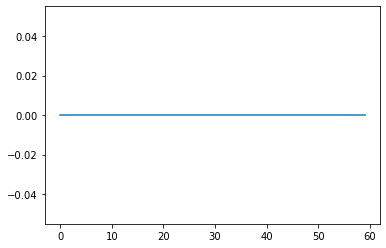

In [20]:
plt.plot(results_one.VFE_post_run)

In [21]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

[0.12643678 0.1768126 ]
[0.12770037 0.17442903]
[0.1294361  0.17261635]
[0.13158748 0.17060891]
[0.13326299 0.16883524]
[0.13388364 0.16703786]
[0.13525562 0.1652819 ]
[0.13569395 0.16295421]
[0.13658956 0.16116865]
[0.13745289 0.15814021]
[0.13856505 0.15699579]
[0.13972741 0.1559071 ]
[0.14118204 0.15431614]
[0.14131513 0.15123852]
[0.14229223 0.14843044]
[0.14303233 0.14599179]
[0.14411312 0.1435683 ]
[0.14526515 0.14228174]
[0.14648373 0.14173934]
[0.14871046 0.13994057]
[0.15032844 0.13823327]
[0.1520063  0.13637826]
[0.15327339 0.13544966]
[0.15546517 0.13274662]
[0.15774284 0.12831914]
[0.15996037 0.12473579]
[0.16294298 0.12147006]
[0.1656171  0.11737504]
[0.16766398 0.11367574]
[0.16984738 0.10923476]
[0.1727904  0.10440448]
[0.17596447 0.10012767]
[0.17885605 0.09427588]
[0.18184501 0.08804055]
[0.18469088 0.08382998]
[0.18897656 0.07993722]
[0.19360839 0.07478351]
[0.19808625 0.07059658]
[0.20304522 0.06531512]
[0.20591204 0.05799587]
[0.13090193 0.18360767]
[0.12930042 0.17

,reward,timesteps,num_actions
0,-142.683333,240,40
1,-160.275509,144,24
2,-144.070711,84,14
3,-160.240566,192,32
4,-118.581080,126,21
5,-132.026663,96,16
6,-146.894146,336,56
7,-157.527405,156,26
8,-147.209805,132,22
9,-193.534703,258,43


In [22]:
daifa.train_vae = False
daifa.model_vae.show_training = False

daifa.train_tran = True
daifa.tran.show_training = True

In [23]:
# train the agent on the env
env = gym.make("LunarLanderContinuous-v2")
daifa, results_two = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=60, render_env=True)

Episode 1
[-0.0074296   1.4090451  -0.7525569  -0.08336726  0.00861586  0.17046544
  0.          0.        ]
Epoch 1/2
1/1 [==============================] - 0s 8ms/step - kl_loss: 5.6372
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - kl_loss: 6.0368
Epoch 1/2
1/1 [==============================] - 0s 8ms/step - kl_loss: 3.9060
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - kl_loss: 4.5965
Epoch 1/2
1/1 [==============================] - 0s 8ms/step - kl_loss: 6.6137
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - kl_loss: 7.0651
Epoch 1/2
1/1 [==============================] - 0s 9ms/step - kl_loss: 9.2782
Epoch 2/2
1/1 [==============================] - 0s 8ms/step - kl_loss: 9.2923
Epoch 1/2
1/1 [==============================] - 0s 8ms/step - kl_loss: 10.0403
Epoch 2/2
1/1 [==============================] - 0s 9ms/step - kl_loss: 9.4404
Epoch 1/2
1/1 [==============================] - 0s 8ms/step - kl_loss: 11.2895
Epoch 2/2
1/1 [=====

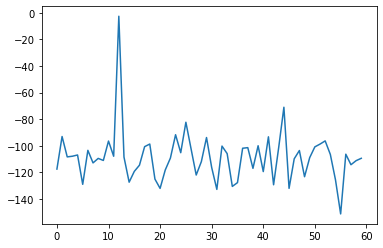

In [49]:
plt.plot(results_two.total_reward)

In [13]:
# # make the HABIT ACTION NET
# habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=True)
# habit_net.compile(optimizer=tf.keras.optimizers.Adam())
#
# daifa.habit_action_model = habit_net
#
# actor_model = get_actor(latent_dim, 1)
# critic_model = get_critic(latent_dim, 1)
#
# target_actor = get_actor(latent_dim, 1)
# target_critic = get_critic(latent_dim, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
#
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
#
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [14]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-4.082868,1002,167
1,-3.421810,1002,167
2,-4.038446,1002,167
3,-3.973020,1002,167
4,-3.670363,1002,167
5,-4.174999,1002,167
6,-3.983523,1002,167
7,-3.491283,1002,167
8,-3.724104,1002,167
9,-3.982118,1002,167


In [15]:
daifa.habit_action_model.show_training = False
daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_kl_intrinsic = True
daifa.use_kl_extrinsic = False
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

# daifa.tran.show_training = False
# daifa.prior_model.show_training = False

# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_three = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.4251048  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
42 147
Success in episode 1 at time step 881
Episode 2
[-0.4140919  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
12 53
Success in episode 2 at time step 317
Episode 3
[-0.4

In [16]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-4.354593,1002,167
1,-4.322005,1002,167
2,-4.579960,1002,167
3,-4.346885,1002,167
4,-4.402006,1002,167
5,-4.537839,1002,167
6,-4.509408,1002,167
7,-3.877914,1002,167
8,-4.507214,1002,167
9,-4.078587,1002,167


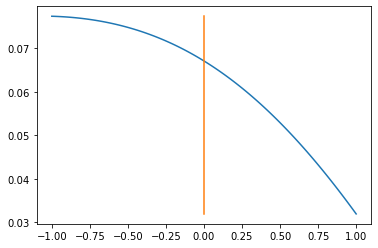

In [17]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

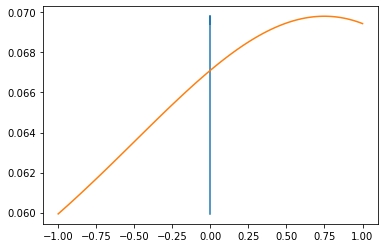

In [18]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

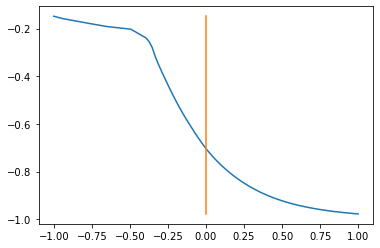

In [19]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

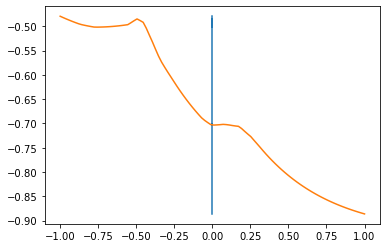

In [20]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [21]:
env = gym.make('MountainCarContinuous-v0')
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 5, daifa.agent_time_ratio, show_env=True)
res


KeyboardInterrupt



In [22]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=False)

Episode 1
[-0.4574806  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
60 167
No Success
Episode 2
[-0.47844926  0.        ]
fast thinking
fast thinking
fast thi

In [23]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-3.227861,1002,167
1,-2.494721,1002,167
2,-3.008866,1002,167
3,-3.164953,1002,167
4,-2.522984,1002,167
5,-3.145121,1002,167
6,-3.130102,1002,167
7,-3.264508,1002,167
8,-2.171139,1002,167
9,-3.021667,1002,167


In [180]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=True)

Episode 1
[-0.43750945  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on 

In [163]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-6.068081,1002,167
1,-6.230983,1002,167
2,-6.431071,1002,167
3,-6.138415,1002,167
4,-6.204773,1002,167
5,-6.439107,1002,167
6,-6.316643,1002,167
7,-6.352924,1002,167
8,-6.375400,1002,167
9,-6.346141,1002,167


In [164]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 4, daifa.agent_time_ratio, show_env=False)
res

,reward,timesteps,num_actions
0,-6.402275,1002,167
1,-6.180096,1002,167
2,-6.352802,1002,167
3,-6.167919,1002,167


In [ ]:
full_results = pd.concat([results_one, results_two, results_three, results_four])
full_results.reset_index(drop=True)
full_results

In [ ]:
T = np.arange(len(full_results))
plt.plot(T, full_results.percent_use_fast_thinking)

In [ ]:
plt.plot(T, full_results.success)

In [ ]:
plt.plot(T, full_results.total_reward)

In [ ]:
plt.plot(T, full_results.sim_steps)